<a href="https://colab.research.google.com/github/smoralesc91/DataScience2024/blob/main/T1_mod_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import __version__ as mpl_version
import seaborn as sns
from scipy import __version__ as sp_version
import scipy.stats as stats
from scipy.stats import norm
from sklearn.metrics import r2_score
from sklearn import __version__ as skl_version

print('pandas version:', pd.__version__)
print('numpy version:', np.__version__)
print('matplotlib version:', mpl_version)
print('seaborn version:', sns.__version__)
print('scipy version:', sp_version)
print('sklearn version:', skl_version)

pandas version: 1.5.3
numpy version: 1.25.2
matplotlib version: 3.7.1
seaborn version: 0.13.1
scipy version: 1.11.4
sklearn version: 1.2.2


# Merge Registros geofisicos con datos núcleo

In [25]:
url = 'https://raw.githubusercontent.com/smoralesc91/DataScience2024/5e43cd1fc76b2a1d00ff30e3e4ef4c6fca3eb2ed/Data/well_data_rev1.csv'
data = pd.read_csv(url)
data

,DEPTH,CALI,GR,ILD,PEF,RHOB,NPHI,SHALE
0,5000.0,8.8,125,2.6,2.6,2.199,0.403,1
1,5000.5,8.8,129,2.5,2.7,2.209,0.373,1
2,5001.0,8.8,133,2.6,2.9,2.232,0.378,1
3,5001.5,8.8,142,2.8,3.1,2.268,0.386,1
4,5002.0,8.7,147,3.1,2.9,2.295,0.375,1
...,...,...,...,...,...,...,...,...
1196,5598.0,7.5,35,64.6,4.7,2.671,0.017,0
1197,5598.5,7.5,34,68.5,4.9,2.673,0.017,0
1198,5599.0,7.5,32,71.8,4.8,2.672,0.015,0
1199,5599.5,7.5,31,73.3,4.9,2.676,0.015,0


In [26]:
data.describe()

,DEPTH,CALI,GR,ILD,PEF,RHOB,NPHI,SHALE
count,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000
mean,5300.000000,8.644130,76.518734,25.347377,3.320733,2.550055,0.195087,0.562864
std,173.421572,1.154275,38.601229,40.978320,0.711321,0.115164,0.131611,0.496239
min,5000.000000,7.300000,15.000000,2.300000,1.800000,1.891000,0.006000,0.000000
25%,5150.000000,7.500000,31.000000,3.600000,2.900000,2.475000,0.056000,0.000000
50%,5300.000000,8.500000,97.000000,4.800000,3.200000,2.568000,0.257000,1.000000
75%,5450.000000,9.500000,108.000000,19.500000,3.700000,2.638000,0.306000,1.000000
max,5600.000000,12.200000,153.000000,165.400000,5.300000,2.773000,0.467000,1.000000


# Funciones


In [29]:
def estadistica_basica(info):
  n=len(info)
  minimo=np.min(info)

  q1=np.percentile(info,25)
  mediana=np.percentile(info,50)
  media=np.mean(info)
  q3=np.percentile(info,75)
  maximo=np.max(info)
  rango=maximo-minimo
  iqr=q3-q1
  varianza=info.var()
  desviacion_estandar=np.std(info)
  skewness=np.mean((info-media)**3)/(desviacion_estandar**3)
  k=np.mean(((info-media)/desviacion_estandar)**4)
  eb=n,minimo,q1,mediana,media,q3,maximo,rango, iqr,varianza,desviacion_estandar,skewness, k

  etiquetas = ['n', 'minimo', 'q1', 'mediana', 'media', 'q3', 'maximo', 'rango', 'iqr', 'varianza', 'desviacion_estandar', 'skewness', 'k']

  #estadistica_calculada = pd.DataFrame(etiquetas, columns=['Etiqueta'])
  estadistica_calculada= pd.DataFrame({'Etiqueta': etiquetas, 'Valor Numerico': eb})


  return estadistica_calculada

In [28]:
def plotxy(dx, dy):
    # Crear una figura con 1 fila y 4 columnas
    column_headers = data.columns.tolist()
    y_column = column_headers[1]  # Porosity
    x_column = column_headers[0]  # Depth
    # Datos para la gráfica
    x_data = data[x_column]
    y_data = data[y_column]

    fig = plt.figure(figsize=(10, 10))

    # Tamaño y ubicación de los subplots utilizando subplot2grid
    ax_disp = plt.subplot2grid((7, 7), (3, 0), colspan=4, rowspan=4)
    ax_info = plt.subplot2grid((7, 7), (0, 4), colspan=3, rowspan=3)
    ax_hist_v1 = plt.subplot2grid((7, 7), (0, 0), colspan=4, rowspan=2)
    ax_box_cadmio = plt.subplot2grid((7, 7), (2, 0), colspan=4)
    ax_hist_v2 = plt.subplot2grid((7, 7), (3, 5), colspan=2, rowspan=4)
    ax_box_plomo = plt.subplot2grid((7, 7), (3, 4), rowspan=4)

    # Graficar el gráfico de dispersión
    ax_disp.scatter(dx, dy)
    ax_disp.set(xlabel=x_column, ylabel=y_column)

    # Ajustar una línea de regresión lineal en la gráfica de dispersión
    m, b = np.polyfit(dx, dy, 1)
    ax_disp.plot(dx, m * dx + b, color='red', label='Tendecy line')

    # Agregar la ecuación de la línea de regresión en el gráfico
    equation_text = f' y = {m:.2f}x + {b:.2f}'
    plt.text(0.05, 0.9, equation_text, transform=ax_disp.transAxes, fontsize=12, color='red')

    # Graficas el histograma del cadmio en la parte superior
    datos1 = dx
    n1 = len(datos1)
    k1 = 1 + int(np.log2(n1))

    ax_hist_v1.hist(datos1, bins=k1, orientation='vertical', color='skyblue', edgecolor='black')
    ax_hist_v1.set(ylabel='Frecuency')

    # Eliminar las marcas de los ejes x e y en ax_info
    ax_info.set_xticks([])
    ax_info.set_yticks([])

    # Calcular la media y la mediana
    media = np.mean(datos1)
    mediana = np.median(datos1)

    # Agregar líneas verticales para la media y la mediana en el subplot de distribución
    ax_hist_v1.axvline(media, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {media:.2f}')
    ax_hist_v1.axvline(mediana, color='green', linestyle='dashed', linewidth=2, label=f'Median: {mediana:.2f}')
    ax_hist_v1.legend()

    # Graficar el boxplot horizontal del cadmio en la parte superior
    sns.boxplot(x=dx, ax=ax_box_cadmio, orient='h', width=0.1)

    ax_box_cadmio.set(xticklabels=[], yticklabels=[])
    ax_box_cadmio.set_title('')


    # Graficar el histograma del plomo en la parte lateral derecha
    datos = dy
    n = len(datos)
    k = 1 + int(np.log2(n))

    ax_hist_v2.hist(datos, bins=k, orientation='horizontal', color='skyblue', edgecolor='black')
    ax_hist_v2.set(xlabel='Frecuency')

    # Calcular la media y la mediana
    media = np.mean(datos)
    mediana = np.median(datos)

    # Agregar líneas verticales para la media y la mediana en el subplot de distribución
    ax_hist_v2.axhline(media, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {media:.2f}')
    ax_hist_v2.axhline(mediana, color='green', linestyle='dashed', linewidth=2, label=f'Median: {mediana:.2f}')
    ax_hist_v2.legend()

    # Graficar el boxplot vertical del plomo en la parte lateral derecha
    sns.boxplot(y=dy, ax=ax_box_plomo, orient='v', width=0.1)
    ax_box_plomo.set(xticklabels=[], yticklabels=[])
    ax_box_plomo.set_title('')

    # Agregar texto al gráfico
    p = dx.corr(dy)
    s = dx.corr(dy, method='spearman')
    k= dx.corr(dy, method='kendall')

    # Coeficiente de correlación R^2
    m, b = np.polyfit(dx, dy, 1)
    y_pred = m * dx + b
    r2 = r2_score(dy, y_pred)

    ax_info.text(0.2, 0.9, f'Pearson: {p:.2f}', fontsize=12, color='black')
    ax_info.text(0.2, 0.8, f'Spearman: {s:.2f}', fontsize=12, color='black')
    ax_info.text(0.2, 0.7, f'Kendall: {k:.2f}', fontsize=12, color='black')
    ax_info.text(0.2, 0.6, f'R^2: {r2:.2f}', fontsize=12, color='black')

    # Ajustar la posición de los subplots
    plt.subplots_adjust(wspace=0.5, hspace=0.6)  # Espacio entre los subplots

    # Mostrar el gráfico
    plt.show()

In [30]:
def regresion_lineal(dx,dy):
  m, b = np.polyfit(dx, dy, 1)
  y_pred = m * dx + b
  alma=dy-y_pred
  #alma= pd.DataFrame(dy-y_pred)
  return alma

def crear_graficos_estadisticos(datos):

    # Crear una figura con 1 fila y 4 columnas
    fig = plt.figure(figsize=(10, 10))

    # Tamaño y ubicación de los subplots utilizando subplot2grid
    ax_hist = plt.subplot2grid((8, 8), (0, 0), colspan=4, rowspan=4)
    ax_cdf = plt.subplot2grid((8, 8), (4, 0), colspan=4, rowspan=4)
    ax_qq = plt.subplot2grid((8, 8), (0, 4), colspan=4, rowspan=4)
    ax_pp = plt.subplot2grid((8, 8), (4, 4), colspan=4, rowspan=4)

    # Histograma de residuos
    n1 = len(datos)
    k1 = 1 + int(np.log2(n1))

    ax_hist.hist(datos, bins=k1, orientation='vertical', color='skyblue', edgecolor='black')
    ax_hist.set(ylabel='Frecuencia')
    ax_hist.set(title='Histograma')

    # Calcular la media y la mediana
    media = np.mean(datos)
    mediana = np.median(datos)

    # Agregar líneas verticales para la media y la mediana en el subplot de distribución
    ax_hist.axvline(media, color='red', linestyle='dashed', linewidth=2, label=f'Media: {media:.2f}')
    ax_hist.axvline(mediana, color='green', linestyle='dashed', linewidth=2, label=f'Mediana: {mediana:.2f}')
    ax_hist.legend()

    # QQ plot
    media_ajustada, desviacion_ajustada = stats.norm.fit(datos)
    cuantiles_teoricos = stats.norm.ppf(np.linspace(0.01, 0.99, 155), loc=media_ajustada, scale=desviacion_ajustada)
    datos_ordenados = np.sort(datos)
    m, b = np.polyfit(cuantiles_teoricos, datos_ordenados, 1)

    ax_qq.scatter(cuantiles_teoricos, datos_ordenados, alpha=0.7)
    ax_qq.plot(cuantiles_teoricos, m * cuantiles_teoricos + b, color='red', label='Línea de Tendencia')
    ax_qq.set(ylabel='Cuantiles observados', xlabel='Cuantiles teóricos')
    ax_qq.set(title='Q-Q Plot')

    # CDF
    datos_ordenados = np.sort(datos)
    cdf_empirica = np.arange(1, len(datos_ordenados) + 1) / len(datos_ordenados)

    media, desviacion = norm.fit(datos)
    x = np.linspace(-200, 700, 1000)
    cdf_teorica = norm.cdf(x, loc=media, scale=desviacion)

    ax_cdf.plot(datos_ordenados, cdf_empirica, marker='o', linestyle='-', label='CDF Empírica')
    ax_cdf.plot(x, cdf_teorica, linestyle='--', color='red', label='CDF Teórica (Normal)')
    ax_cdf.set(ylabel='Cuantiles Observados', xlabel='Probabilidad Acumulada Teórica Normalizada', title='CDF Empírica vs. CDF Teórica')

    # PP plot
    datos_ordenados = np.sort(datos)
    cdf_empirica = np.arange(1, len(datos_ordenados) + 1) / len(datos_ordenados)
    media, desviacion = norm.fit(datos)
    x = np.linspace(min(datos), max(datos), 155)
    cdf_teorica = norm.cdf(x, loc=media, scale=desviacion)

    ax_pp.plot(cdf_teorica, cdf_empirica, marker='o', linestyle='', label='CDF Empírica vs. CDF Teórica')
    ax_pp.plot([0, 1], [0, 1], linestyle='--', color='red', label='Línea de Referencia (Igualdad)')
    ax_pp.set(ylabel='Probabilidad empírica', xlabel='Probabilidad teórica', title='PP plot')

    # Ajustar la posición de los subplots
    plt.subplots_adjust(wspace=2, hspace=2)  # Espacio entre los subplots

    # Mostrar el gráfico
    plt.show()


# Puntos de la tarea

1- Obtener la estadística básica: Media, varianza, mediana, cuartiles,
curtosis, Coeficiente de simetría, máximo, mínimo, coeficiente de
variación.

In [32]:
for mnemonicos in np.array(data.keys()):
    print('---------------------')
    print(mnemonicos)
    print('---------------------')
    print(estadistica_basica(data[mnemonicos]))

---------------------
DEPTH
---------------------
               Etiqueta  Valor Numerico
0                     n     1201.000000
1                minimo     5000.000000
2                    q1     5150.000000
3               mediana     5300.000000
4                 media     5300.000000
5                    q3     5450.000000
6                maximo     5600.000000
7                 rango      600.000000
8                   iqr      300.000000
9              varianza    30075.041667
10  desviacion_estandar      173.349358
11             skewness        0.000000
12                    k        1.799998
---------------------
CALI
---------------------
               Etiqueta  Valor Numerico
0                     n     1201.000000
1                minimo        7.300000
2                    q1        7.500000
3               mediana        8.500000
4                 media        8.644130
5                    q3        9.500000
6                maximo       12.200000
7                 ran

In [33]:
def plot_boxplot_histogram(data, log=False):

    mean_val = data.mean()
    median_val = data.median()

    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(7, 4), gridspec_kw={"height_ratios": (1, 8)})

    sns.boxplot(data, orient='h', ax=ax_box)

    sns.histplot(data, ax=ax_hist, bins='sturges', cumulative=False, log_scale=log)

    ax_box.axvline(x=mean_val, color='r', linestyle='--', label='Media')
    ax_box.axvline(x=median_val, color='g', linestyle='--', label='Mediana')
    ax_hist.axvline(x=mean_val, color='r', linestyle='--', label='Media')
    ax_hist.axvline(x=median_val, color='g', linestyle='--', label='Mediana')

    ax_hist.set_ylabel('Frecuencia', fontsize=14)
    ax_hist.set_xlabel(data.name, fontsize=14)

    plt.tight_layout()

    ax_hist.legend()

    plt.show()

---------------------
DEPTH
---------------------


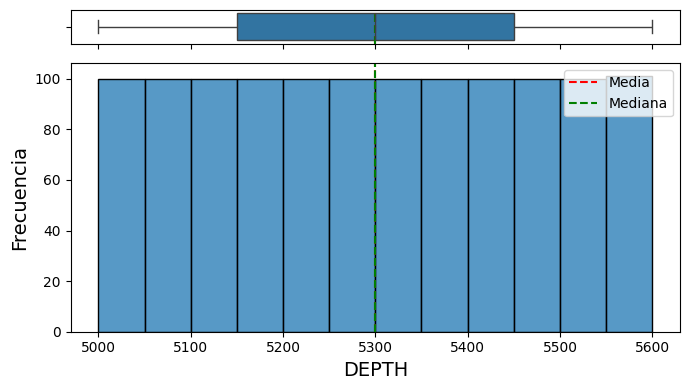

None
---------------------
CALI
---------------------


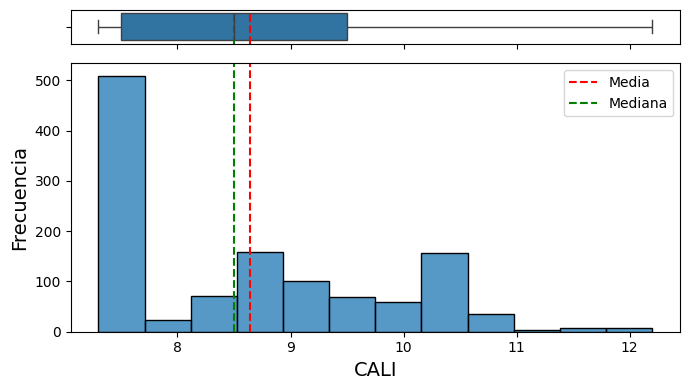

None
---------------------
GR
---------------------


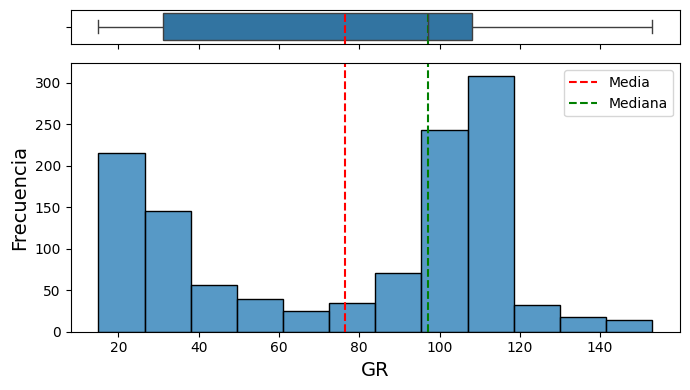

None
---------------------
ILD
---------------------


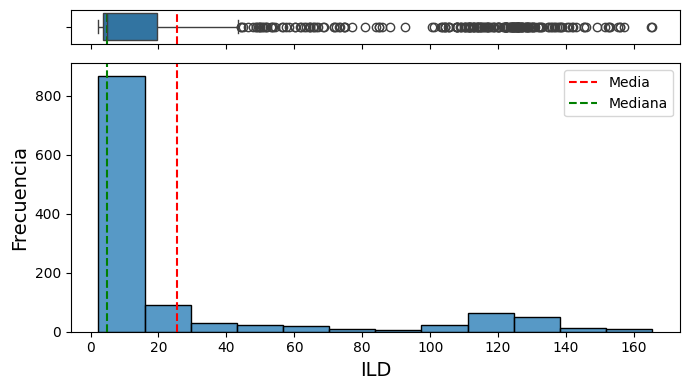

None
---------------------
PEF
---------------------


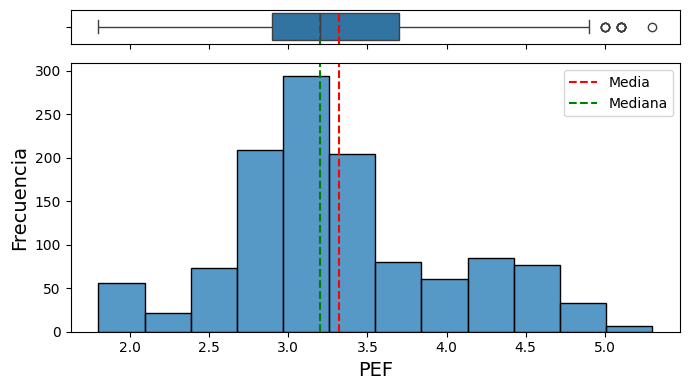

None
---------------------
RHOB
---------------------


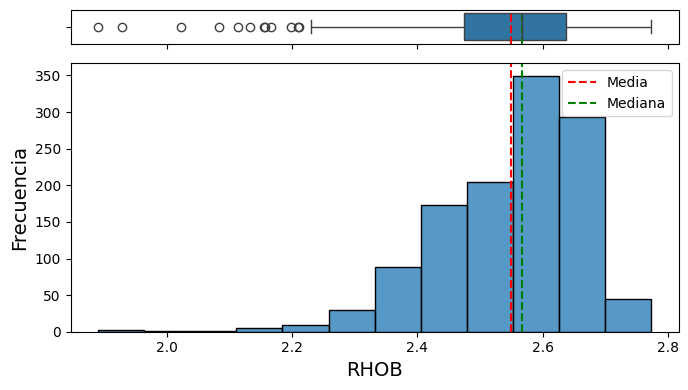

None
---------------------
NPHI
---------------------


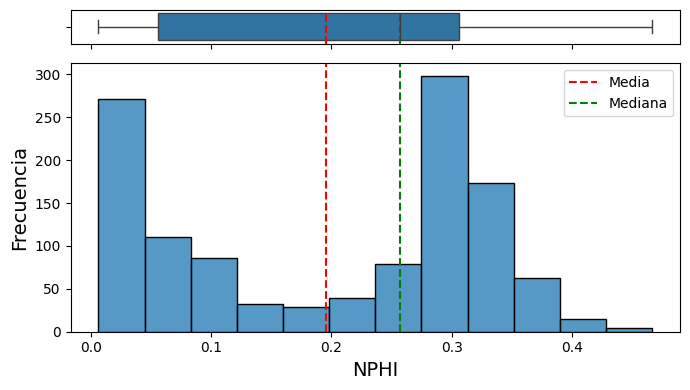

None
---------------------
SHALE
---------------------


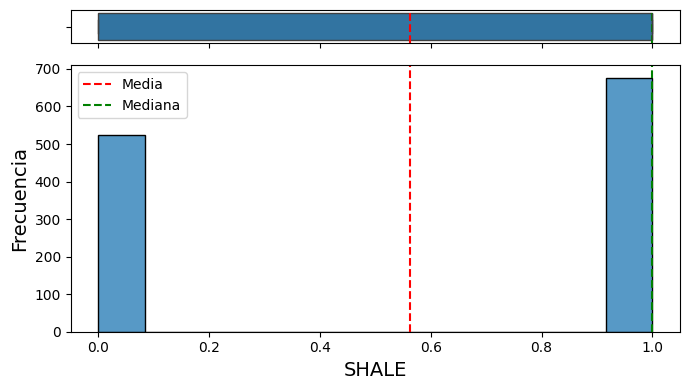

None


In [34]:
for mnemonicos in np.array(data.keys()):
    print('---------------------')
    print(mnemonicos)
    print('---------------------')
    print(plot_boxplot_histogram(data[mnemonicos]))

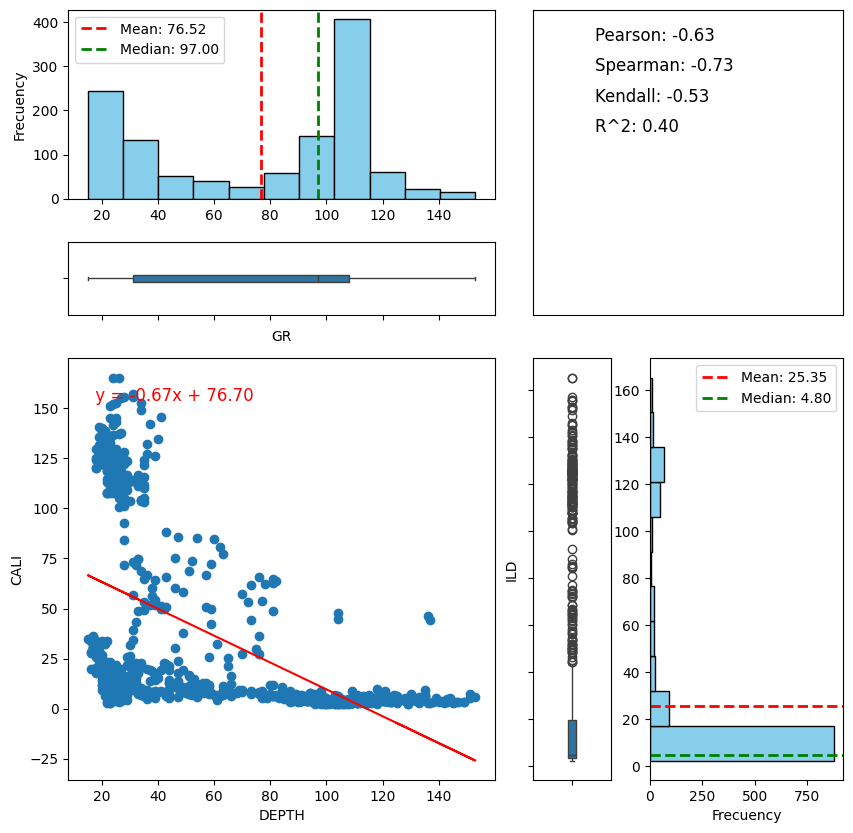

In [37]:
plotxy(data.GR, data.ILD)

In [ ]:
rl=regresion_lineal(df.GR, df.PEF)

In [ ]:
crear_graficos_estadisticos(df.PEF)